# <center>SEIRD Approach in Modeling of the Novel Coronavirus Disease 2019 Dynamics</center>
## <center>Part 2</center>

<center>
    Ante Lojic Kapetanovic <br>
    <a href="alojic00@fesb.hr">alojic00@fesb.hr</a> <br>
    Faculty of electrical engineering, mechanical engineering and naval architecture <br>
    University of Split <br>
    Split, Croatia
</center>

In [1]:
import datetime as dt
import io
import os
import requests

from coropy.compartmental_models import SEIRDModel, SEIRModel
from coropy.growth_models import GrowthCOVIDModel
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize   
from sklearn.metrics import r2_score

import plotting

In [2]:
# configure plotting

plotting.configure(grid=True)
hex_blue = plotting.default_colors('blue')
hex_red = plotting.default_colors('red')
hex_purple = plotting.default_colors('purple')

In [3]:
# data from koronavirus.hr -- machine readable data

URLs = [
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/confirmed_cases.dat',
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/recovered_cases.dat',
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/death_cases.dat',
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/tests.dat'
]

data = []
for URL in URLs:
    response = requests.get(URL)
    data.append(np.loadtxt(io.BytesIO(response.content)))
    
cum_positives, recovered, deceased, tests = data
removed = recovered - deceased
active = cum_positives - removed

    
# start of different epi waves
eff_dates = [dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 10), dt.datetime(2020, 8, 10)]

diff_1 = (eff_dates[1] - eff_dates[0]).days
diff_2 = (eff_dates[2] - eff_dates[1]).days

cum_positives_1 = cum_positives[:diff_1]
cum_positives_2 = cum_positives[diff_1:diff_1+diff_2]
cum_positives_3 = cum_positives[diff_1+diff_2:]

active_1 = active[:diff_1]
active_2 = active[diff_1:diff_1+diff_2]
active_3 = active[diff_1+diff_2:]

recovered_1 = recovered[:diff_1]
recovered_2 = recovered[diff_1:diff_1+diff_2]
recovered_3 = recovered[diff_1+diff_2:]

deceased_1 = deceased[:diff_1]
deceased_2 = deceased[diff_1:diff_1+diff_2]
deceased_3 = deceased[diff_1+diff_2:]

removed_1 = removed[:diff_1]
removed_2 = removed[diff_1:diff_1+diff_2]
removed_3 = removed[diff_1+diff_2:]

tests_1 = tests[:diff_1]
tests_2 = tests[diff_1:diff_1+diff_2]
tests_3 = tests[diff_1+diff_2:]

# First wave simple SEIR extrapolation, full period fit + MCMC

In [4]:
# utils

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


# epi models

def SEIR(t, y, beta, alpha, gamma):
    S, E, I, R = y
    N = S + E + I + R
    return [
        -beta*S*I/N, 
        beta*S*I/N - alpha*E, 
        alpha*E - gamma*I,  ##
        gamma*I,
    ]


def SEIR_extended(t, y, beta, delta, alpha, gamma):
    S, E, I, R = y
    N = S + E + I + R
    return [
        -beta*S*I/N - delta*E, 
        beta*S*I/N - alpha*E + delta*E,
        alpha*E - gamma*I,
        gamma*I,
    ]


def SEIRD(t, y, beta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R
    return [
        -beta*S*I/N, 
        beta*S*I/N - alpha*E, 
        alpha*E - gamma*I -mu*I,
        gamma*I,
        mu*I,
    ]


def SEIRD_extended(t, y, beta, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*E, 
        beta*S*I/N - alpha*E + delta*E, 
        alpha*E - gamma*I - mu*I,
        gamma*I,
        mu*I,
    ]

In [5]:
# loss function

def loss(params, active, IC):
    size = active.size
    sol = solve_ivp(
        fun=SEIR, 
        t_span=(0, size), 
        y0=IC, 
        args=params,
        method='RK45', 
        t_eval=np.arange(0, size, 1), 
        vectorized=True,
    )
    return MSE(sol.y[2], active)

In [6]:
t = np.arange(active_1.size)
end_dt = eff_dates[0] + dt.timedelta(int(t.max())+1)
dates = matplotlib.dates.drange(eff_dates[0], end_dt, dt.timedelta(days=1))
n_future = 45
t_opt = t[:-n_future]
dates_opt = dates[:-n_future]
t_ext = t[-n_future:]
dates_ext = dates[-n_future:]

In [7]:
guess = [0.1, 0.1, 0.1]
S0 = 2_800  # crude approx.
E0 = 10*active_1[0]
I0 = active_1[0]
R0 = removed_1[0]
IC = [S0, E0, I0, R0]

In [8]:
from coropy.compartmental_models import SEIRModel

pcr_sens = 0.9
pcr_spec = 0.97
active_lb_ci, active_lb, active_ub, active_ub_ci = SEIRModel.calculate_ci(
    pcr_sens,
    pcr_spec,
    np.diff(np.concatenate((np.array([0]), cum_positives_1))),
    recovered_1 + deceased_1,
    tests_1)

In [9]:
guess = [0.1, 0.1, 0.1]
S0 = 4_500
E0 = 10*active_1[0]
I0 = active_1[0]
R0 = removed_1[0]
IC = [S0, E0, I0, R0]

opt = minimize(
    fun=loss, 
    x0=guess,
    args=(active_1, IC),
    method='L-BFGS-B',
    bounds=[(1e-5, 1.0)] * len(guess),
    options={'maxiter': 1000, 'disp': True},
)

sol = solve_ivp(
    fun=SEIR, 
    t_span=(0, t[-1]), 
    y0=IC, 
    args=opt.x,
    method='RK45', 
    t_eval=np.arange(0, t.size, 1), 
    vectorized=True,
)


# metropolis-hastings
n_iters = 1000
I = active_1
I_sampled = np.zeros(shape=(n_iters, t.size))

for i in range(n_iters):
    noisy_S0 = np.random.normal(loc=S0, scale=0.2*S0)
    noisy_E0 = np.random.normal(loc=E0, scale=0.2*E0)
    noisy_params = np.random.normal(loc=opt.x, scale=0.2*opt.x, size=opt.x.size)
    noisy_sol = solve_ivp(
        SEIR,
        t_span=(0, int(t[-1])),
        y0=[noisy_S0, noisy_E0, I0, R0],
        args=noisy_params,
        method='RK45',
        t_eval=t,
        vectorized=True,
    )
    if np.mean(noisy_sol.y[2] / I):
        I = noisy_sol.y[2]
    
    I_sampled[i, :] = I

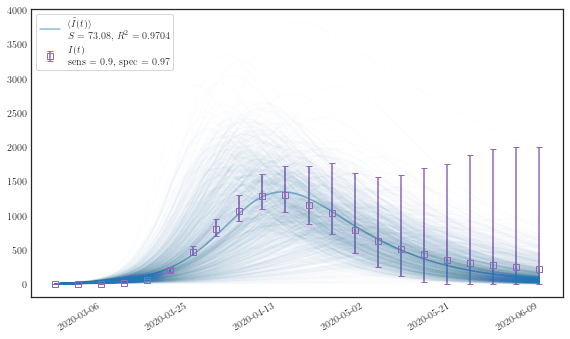

In [10]:
sre_fit = np.sqrt(np.mean((active_1 - sol.y[2])**2))
r2_fit = r2_score(active_1, sol.y[2])

fig = plt.figure()
plt.plot(dates, sol.y[2], '-', c=hex_blue, alpha=0.5, label=f'$\\langle \\tilde{{I}}(t) \\rangle$\n$S = {round(sre_fit, 2)}$, $R^2 = {round(r2_fit, 4)}$')
plt.plot(dates, I_sampled.T, c=hex_blue, alpha=0.01)
plt.errorbar(dates, active_1, 
             yerr=np.r_[
                 (active_1-active_lb).reshape(1, -1),
                 (active_ub-active_1).reshape(1, -1)],
             markevery=5,
             errorevery=5, capsize=3,
             marker='s', linestyle='None', mew=1, mfc='none',
             c=hex_purple,
             label=f'$I(t)$\nsens = ${pcr_sens}$, spec = ${pcr_spec}$')

plt.legend(loc='upper left', frameon=True)
_ = fig.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.grid()
plt.show()
fname = f'MCMC_SEIRD_simple'
fig.savefig(fname=os.path.join('figs', fname + '.pdf'), format='pdf', bbox_inches='tight')
fig.savefig(fname=os.path.join('figs', fname + '.png'), format='png', bbox_inches='tight', dpi = 300)

In [11]:
beta, delta, gamma = opt.x
print(f'beta = {beta}')
print(f'gamma = {gamma} -> t_rec = {1/gamma}')

beta = 0.24830312517945494
gamma = 0.07795922994177346 -> t_rec = 12.827217518014026
